## Importing the libraries

In [74]:
import os
import random
import numpy as np
import cv2

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Lambda
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Import uuid library to generate unique image names
import uuid

In [75]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

### Setup the Folders

In [76]:
# Setup paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [77]:
# Make the directories
os.makedirs(POS_PATH, exist_ok=True)
os.makedirs(NEG_PATH, exist_ok=True)
os.makedirs(ANC_PATH, exist_ok=True)

## Collect and preprocess data

In [8]:
# http://vis-www.cs.umass.edu/lfw/

# Uncompress Tar GZ Labelled Faces in the Wild Dataset
!tar -xf lfw.tgz

# Move LFW Images to the following repository data/negative
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

lfw/Vladimir_Putin/Vladimir_Putin_0008.jpg: Can't unlink already-existing object
tar: Error exit delayed from previous errors.


In [78]:
os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))

'data\\anchor\\4b163aca-82c9-11ef-95cc-04421a97446c.jpg'

In [28]:
# Establish a connection to the webcam
cap = cv2.VideoCapture(0)
while cap.isOpened(): 
    ret, frame = cap.read()
   
    # Cut down frame to 250x250px
    frame = frame[120:120+250,200:200+250, :]
    
    # Collect anchors 
    if cv2.waitKey(1) & 0XFF == ord('a'):
        # Create the unique file path 
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out anchor image
        cv2.imwrite(imgname, frame)
    
    # Collect positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        # Create the unique file path 
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out positive image
        cv2.imwrite(imgname, frame)
    
    # Show image back to screen
    cv2.imshow('Image Collection', frame)
    
    # Breaking gracefully
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
        
# Release the webcam
cap.release()
# Close the image show frame
cv2.destroyAllWindows()

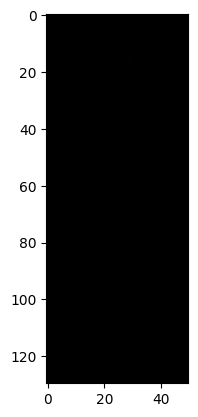

In [79]:
plt.imshow(frame[120:120+250,200:200+250, :])

### Data Augmentation

In [80]:
def data_aug(img):
    data = []
    for i in range(9):
        img = tf.image.stateless_random_brightness(img, max_delta=0.02, seed=(1,2))
        img = tf.image.stateless_random_contrast(img, lower=0.6, upper=1, seed=(1,3))
        # img = tf.image.stateless_random_crop(img, size=(20,20,3), seed=(1,2))
        img = tf.image.stateless_random_flip_left_right(img, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_jpeg_quality(img, min_jpeg_quality=90, max_jpeg_quality=100, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_saturation(img, lower=0.9,upper=1, seed=(np.random.randint(100),np.random.randint(100)))
            
        data.append(img)
    
    return data

In [81]:
img_path = os.path.join(ANC_PATH, '6bb81fcc-82ab-11ef-91e3-04421a97446c.jpg')
img = cv2.imread(img_path)
augmented_images = data_aug(img)

for image in augmented_images:
    cv2.imwrite(os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())

In [82]:
for file_name in os.listdir(os.path.join(POS_PATH)):
    img_path = os.path.join(POS_PATH, file_name)
    img = cv2.imread(img_path)
    augmented_images = data_aug(img) 
    
    for image in augmented_images:
        cv2.imwrite(os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())

In [83]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(3000)
positive = tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(3000)
negative = tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(3000)

In [84]:
dir_test = anchor.as_numpy_iterator()

In [85]:
print(dir_test.next())

b'data\\anchor\\8aa2c64f-82ab-11ef-9634-04421a97446c.jpg'


### Preprocessing - Scale and Resize

In [86]:
def preprocess(file_path):
    
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image 
    img = tf.io.decode_jpeg(byte_img)
    
    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100,100))
    # Scale image to be between 0 and 1 
    img = img / 255.0

    # Return image
    return img

In [87]:
img = preprocess('data\\anchor\\6bb81fcc-82ab-11ef-91e3-04421a97446c.jpg')

In [88]:
img.numpy().max()

0.012254902

In [89]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [90]:
samples = data.as_numpy_iterator()

In [91]:
example = samples.next()

In [92]:
example

(b'data\\anchor\\686f85d3-82ab-11ef-8ecc-04421a97446c.jpg',
 b'data\\positive\\52007ec8-82c9-11ef-b665-04421a97446c.jpg',
 1.0)

In [93]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [94]:
res = preprocess_twin(*example)

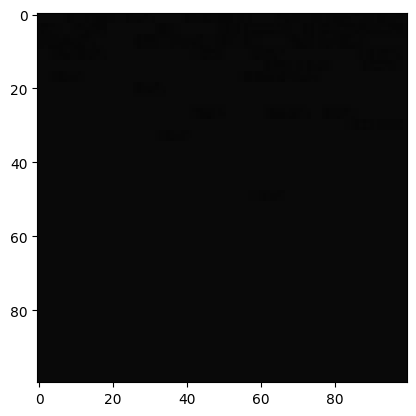

In [95]:
plt.imshow(res[1])

In [96]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=10000)

In [97]:
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [98]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

## Building the Architecture and Training the Model

### Architecture

In [99]:
# Define the base network
def create_base_network():
    inputs = Input(shape=(100,100,3), name='input_image')

    # Layer 1
    conv1 = Conv2D(64, (10, 10), activation='relu')(inputs)
    pool1 = MaxPooling2D(64, (2,2), padding='same')(conv1)

    # Layer 2
    conv2 = Conv2D(128, (7, 7), activation='relu')(pool1)
    pool2 = MaxPooling2D(64, (2,2), padding='same')(conv2)

    # Layer 3
    conv3 = Conv2D(128, (4, 4), activation='relu')(pool2)
    pool3 = MaxPooling2D(64, (2,2), padding='same')(conv3)

    # Layer 4
    conv4 = Conv2D(256, (4, 4), activation='relu')(pool3)
    
    # Flatten the output of the last convolutional layer
    flat = Flatten()(conv4)

    # Fully connected layer
    dense1 = Dense(4096, activation='sigmoid')(flat)
    drop = Dropout(0.2)(dense1) 

    # Define the base model
    base_network = Model(inputs=inputs, outputs=dense1)
    base_network.summary()

    return Model(inputs=inputs, outputs=drop, name='embedding')

In [100]:
# Create the base network
base_network = create_base_network()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_9 (Conv2D)           (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 46, 46, 64)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 20, 20, 128)      0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 17, 17, 128)       2622

In [101]:
def make_siamese_model(base_network):
    # Define the inputs for the Siamese Network
    input_a = Input(name='input_img', shape=(100, 100, 3))
    input_b = Input(name='validation_img', shape=(100, 100, 3))

    # Process both inputs using the shared base network
    processed_a = base_network(input_a)
    processed_b = base_network(input_b)

    # Define a Lambda layer for computing the absolute difference between the two embeddings
    # This will serve as the similarity measure between the two inputs
    distance = Lambda(lambda tensors: K.abs(tensors[0] - tensors[1]))([processed_a, processed_b])

    # Define the fully connected layers and output layer for similarity scoring
    classifier = Dense(1, activation='sigmoid')(distance)
    
    # Create the Siamese model
    model = Model(inputs=[input_a, input_b], outputs=classifier, name='SiameseNetwork')

    # Compile the model with a binary cross-entropy loss (since we are dealing with a similarity score)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    # Print the model summary
    model.summary()

    # Return the Siamese model
    return model

In [102]:
siamese_model = make_siamese_model(base_network)

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

In [105]:
# Define the checkpoints and early stopping
checkpoint_dir = './training_checkpoints'

# Create checkpoint directory if it doesn't exist
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

opt = tf.keras.optimizers.Adam()

# Create the checkpoint for saving the model and optimizer state
checkpoint = tf.train.Checkpoint(optimizer=opt, siamese_model=siamese_model)

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

In [106]:
# Train the Siamese Network
history = siamese_model.fit([X_train_a, X_train_b], 
                            y_train,
                            batch_size=16,
                            epochs=50,  # Adjust the number of epochs as necessary
                            validation_split=0.2,
                            callbacks=[early_stopping])

# Save the model and optimizer state after training
checkpoint.save(file_prefix=os.path.join(checkpoint_dir, 'ckpt'))

siamese_model.save('siamesemodel.h5')

NameError: name 'X_train_a' is not defined

In [ ]:
# Reload model using custom_objects with the Lambda function or K.abs directly
siamese_model = tf.keras.models.load_model('siamesemodel.h5',
    custom_objects={'<lambda>': Lambda(lambda tensors: K.abs(tensors[0] - tensors[1])), 
                    'BinaryCrossentropy': tf.losses.BinaryCrossentropy}
)

## Evaluate the Model

### Predictions

In [ ]:
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()
y_hat = siamese_model.predict([test_input, test_val])

# Post processing the results 
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

In [ ]:
y_true

### Calculate Metrics

In [ ]:
# Creating a metric object 
m = Recall()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

In [ ]:
# Creating a metric object 
m = Precision()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

In [ ]:
r = Recall()
p = Precision()

for test_input, test_val, y_true in test_data.as_numpy_iterator():
    yhat = siamese_model.predict([test_input, test_val])
    r.update_state(y_true, yhat)
    p.update_state(y_true,yhat) 

print(r.result().numpy(), p.result().numpy())

### Visualing the Results

In [ ]:
r = Recall()
p = Precision()

for test_input, test_val, y_true in test_data.as_numpy_iterator():
    yhat = siamese_model.predict([test_input, test_val])
    r.update_state(y_true, yhat)
    p.update_state(y_true,yhat) 

print(r.result().numpy(), p.result().numpy())